In [1]:
import flappy_bird_gymnasium
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import gym
from gym import spaces
import pygame
import random
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback
import sys


In [2]:
# import os
# import sys
# # Fügen Sie den Pfad zum 'train'-Verzeichnis hinzu
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(_file_), '..', 'train')))

# # Fügen Sie den Pfad zum 'train'-Verzeichnis hinzu
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..', 'train')))

# # Importieren Sie die Klasse
# from classes import CustomFlappyBirdEnv

# # Registrieren Sie die benutzerdefinierte Umgebung
# gym.envs.registration.register(
#     id='CustomFlappyBird-v0',
#     entry_point='__main__:CustomFlappyBirdEnv',
#     max_episode_steps=100000,
# )

# # Environment erstellen
# env = gym.make("CustomFlappyBird-v0", render_mode='human', use_lidar=False)

In [28]:
number_episodes= 2000
list_alpha = [0.01, 0.5]
list_gamma = [0.9, 1]
list_epsilon =[0.01,0.2]
class metrics:
    liste = []
    standard = 0
    name = ""
Alpha = metrics
Alpha.liste = [0.01, 0.5]
Alpha.standard = 0.1
Alpha.name = "alpha"
Gamma = metrics
Gamma.liste= [0.9, 0.99]
Gamma.standard = 0.99
Gamma.name = "gamma"
Epsilon = metrics
Epsilon.liste= [0.01,0.2]
Epsilon.standard = 0.1
Epsilon.name = "epsilon"

In [5]:
# # Registrierung der Umgebung
# gym.envs.registration.register(
#     id='FlappyBird-v0',
#     entry_point=FlappyBirdEnv,
#     max_episode_steps=10000,
# )

# # Verwendung der benutzerdefinierten Umgebung
# env = gym.make('FlappyBird-v0')

In [29]:
number_episodes=2000    

# Environment with static pipes

### Fixed Pipes

In [50]:
import numpy as np
import random
import gym
from gym import spaces
import pygame
list_rewards = []
list_pipes = []
class FlappyBirdEnv(gym.Env):
    metadata = {'render_modes': ['human']}
    
    def __init__(self):
        super(FlappyBirdEnv, self).__init__()
        self.screen_width = 288
        self.screen_height = 512
        self.pipe_gap = 200
        self.bird_y = self.screen_height // 2
        self.bird_x = self.screen_width // 4
        self.gravity = 1
        self.jump_strength = -10
        self.pipe_width = 50
        self.pipe_velocity = -5
        self.pipe_x = self.screen_width  # Static x-position for pipes
        
        self.action_space = spaces.Discrete(2)  # 0: No flap, 1: Flap
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0, 0], dtype=np.float32),
            high=np.array([self.screen_width, self.screen_height, self.screen_width, self.screen_height], dtype=np.float32)
        )
        
        self.screen = None
        self.clock = None
        self.done = False
        self.bird_vel_y = 0
        self.score = 0
        self.pipes = []
        self.passed_pipes = 0
        self.seed_value = 42  # Seed für reproduzierbare Rohre
        
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.bird_y = self.screen_height // 2
        self.bird_x = self.screen_width // 4
        self.bird_vel_y = 0
        self.done = False
        self.score = 0
        self.passed_pipes = 0
        self._set_seed()
        self.pipes = self._create_fixed_pipes()
        return self._get_observation(), {}
    
    def step(self, action):
        if action == 1:
            self.bird_vel_y = self.jump_strength
        self.bird_vel_y += self.gravity
        self.bird_y += self.bird_vel_y
        
        if self.bird_y < 0:
            self.bird_y = 0
            self.done = True
        if self.bird_y > self.screen_height:
            self.bird_y = self.screen_height
            self.done = True
        
        self._move_pipes()
        self._check_collision()
        
        # Reward für jede Zeiteinheit
        reward =0
        
        # Zusätzlicher Reward für das Passieren eines Rohrs
        if self._passed_pipe():
            reward += 100
            self.passed_pipes += 1
            #print(f"Pipe passed! Total pipes passed: {self.passed_pipes}")
        
        # Bestrafung für das Sterben
        if self.done:
            reward -= 10
        
        observation = self._get_observation()
        info = {'pipe_count': self.passed_pipes}
        return observation, reward, self.done, False, info
    
    def render(self, mode='human'):
        if self.screen is None:
            pygame.init()
            self.screen = pygame.display.set_mode((self.screen_width, self.screen_height))
            self.clock = pygame.time.Clock()
        
        self.screen.fill((0, 0, 255))
        pygame.draw.circle(self.screen, (255, 255, 0), (self.bird_x, self.bird_y), 20)
        
        for pipe in self.pipes:
            pygame.draw.rect(self.screen, (0, 255, 0), pipe['top'])
            pygame.draw.rect(self.screen, (0, 255, 0), pipe['bottom'])
        
        pygame.display.flip()
        self.clock.tick(30)
    
    def close(self):
        if self.screen is not None:
            pygame.quit()
            self.screen = None
    
    def _create_fixed_pipes(self):
        # Create fixed pipes positions
        pipes = []
        x_positions = [self.screen_width + i * 3 * self.pipe_width for i in range(5)]
        for x in x_positions:
            gap_start = random.randint(0, self.screen_height - self.pipe_gap)
            top_rect = pygame.Rect(x, 0, self.pipe_width, gap_start)
            bottom_rect = pygame.Rect(x, gap_start + self.pipe_gap, self.pipe_width, self.screen_height)
            pipes.append({'top': top_rect, 'bottom': bottom_rect, 'passed': False})
        return pipes
    
    def _move_pipes(self):
        for pipe in self.pipes:
            pipe['top'].x += self.pipe_velocity
            pipe['bottom'].x += self.pipe_velocity
        
        if self.pipes and self.pipes[0]['top'].x < -self.pipe_width:
            self.pipes.pop(0)
        
        if not self.pipes or self.pipes[-1]['top'].x < self.screen_width - 3 * self.pipe_width:
            self.pipes.append(self._create_pipe())
    
    def _check_collision(self):
        if self.bird_y >= self.screen_height or self.bird_y <= 0:
            self.done = True
            return
        
        bird_rect = pygame.Rect(self.bird_x, self.bird_y, 20, 20)
        for pipe in self.pipes:
            if bird_rect.colliderect(pipe['top']) or bird_rect.colliderect(pipe['bottom']):
                self.done = True
                return
    
    def _get_observation(self):
        pipe = self.pipes[0]
        return np.array([self.bird_x, self.bird_y, pipe['top'].x, pipe['top'].bottom], dtype=np.float32)

    def _passed_pipe(self):
        for pipe in self.pipes:
            if not pipe['passed'] and pipe['top'].x < self.bird_x:
                pipe['passed'] = True
                return True
        return False
    
    def _set_seed(self):
        random.seed(self.seed_value)
        np.random.seed(self.seed_value)

class QLearningAgent:
    def __init__(self, state_bins, num_actions, alpha=0.1, gamma=0.99, epsilon=0.1, observation_space=None):
        self.state_bins = state_bins
        self.num_actions = num_actions
        self.alpha = alpha  # Lernrate
        self.gamma = gamma  # Diskontierungsfaktor
        self.epsilon = epsilon  # Epsilon für epsilon-greedy Policy
        self.q_table = np.zeros((*state_bins, num_actions))
        self.observation_space = observation_space

    def discretize(self, state):
        state_indices = []
        for i in range(len(state)):
            idx = np.digitize(state[i], np.linspace(0, self.observation_space.high[i], self.state_bins[i])) - 1
            idx = min(self.state_bins[i] - 1, max(0, idx))  # Ensure idx is within bounds
            state_indices.append(idx)
        return tuple(state_indices)

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(range(self.num_actions))  # Zufällige Aktion (explore)
        else:
            return np.argmax(self.q_table[state])  # Beste Aktion (exploit)

    def update(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.gamma * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.alpha * td_error

    def train(self, env, num_episodes):
        total_rewards = []
        pipes_passed = []
        for episode in range(num_episodes):
            state, _ = env.reset()
            state = self.discretize(state)
            done = False
            episode_reward = 0
            episode_pipes = 0
            while not done:
                action = self.choose_action(state)
                next_state, reward, done, truncated, info = env.step(action)
                next_state = self.discretize(next_state)
                self.update(state, action, reward, next_state)
                state = next_state
                episode_reward += reward
                episode_pipes = info.get('pipe_count', episode_pipes)
            total_rewards.append(episode_reward)
            pipes_passed.append(episode_pipes)
            print(f"Episode {episode + 1}/{num_episodes} completed, Reward: {episode_reward}, Pipes Passed: {episode_pipes}")
            list_rewards.append(episode_reward)
            list_pipes.append(episode_pipes)
        return total_rewards, pipes_passed

    def evaluate(self, env, num_episodes=10):
        evaluation_rewards = []
        evaluation_pipes_passed = []
        for episode in range(num_episodes):
            state, _ = env.reset()
            state = self.discretize(state)
            done = False
            episode_reward = 0
            episode_pipes = 0
            while not done:
                action = np.argmax(self.q_table[state])
                next_state, reward, done, truncated, info = env.step(action)
                next_state = self.discretize(next_state)
                state = next_state
                episode_reward += reward
                episode_pipes = info.get('pipe_count', episode_pipes)
            evaluation_rewards.append(episode_reward)
            evaluation_pipes_passed.append(episode_pipes)
            print(f"Evaluation Episode {episode + 1}/{num_episodes} completed, Reward: {episode_reward}, Pipes Passed: {episode_pipes}")
        return evaluation_rewards, evaluation_pipes_passed

    def save(self, filename):
        np.save(filename, self.q_table)
        
    def load(self, filename):
        self.q_table = np.load(filename)

# Verwendung der benutzerdefinierten Umgebung und des Q-Learning-Agenten
env = FlappyBirdEnv()
state_bins = (10, 10, 10, 10)  # Diskretisierung in 10 Bins pro Zustandsdimension
num_actions = env.action_space.n

agent = QLearningAgent(state_bins=state_bins, num_actions=num_actions, observation_space=env.observation_space)
number_episodes = 2000  # Beispielwert, setze dies entsprechend deiner Bedürfnisse
rewards, pipes_passed = agent.train(env, num_episodes=number_episodes)

# Speichern der trainierten Q-Tabelle
agent.save('trained_q_table.npy')



Episode 1/2000 completed, Reward: -10, Pipes Passed: 0
Episode 2/2000 completed, Reward: -10, Pipes Passed: 0
Episode 3/2000 completed, Reward: -10, Pipes Passed: 0
Episode 4/2000 completed, Reward: -10, Pipes Passed: 0
Episode 5/2000 completed, Reward: -10, Pipes Passed: 0
Episode 6/2000 completed, Reward: -10, Pipes Passed: 0
Episode 7/2000 completed, Reward: -10, Pipes Passed: 0
Episode 8/2000 completed, Reward: -10, Pipes Passed: 0
Episode 9/2000 completed, Reward: -10, Pipes Passed: 0
Episode 10/2000 completed, Reward: -10, Pipes Passed: 0
Episode 11/2000 completed, Reward: -10, Pipes Passed: 0
Episode 12/2000 completed, Reward: -10, Pipes Passed: 0
Episode 13/2000 completed, Reward: -10, Pipes Passed: 0
Episode 14/2000 completed, Reward: -10, Pipes Passed: 0
Episode 15/2000 completed, Reward: -10, Pipes Passed: 0
Episode 16/2000 completed, Reward: -10, Pipes Passed: 0
Episode 17/2000 completed, Reward: -10, Pipes Passed: 0
Episode 18/2000 completed, Reward: -10, Pipes Passed: 0
E

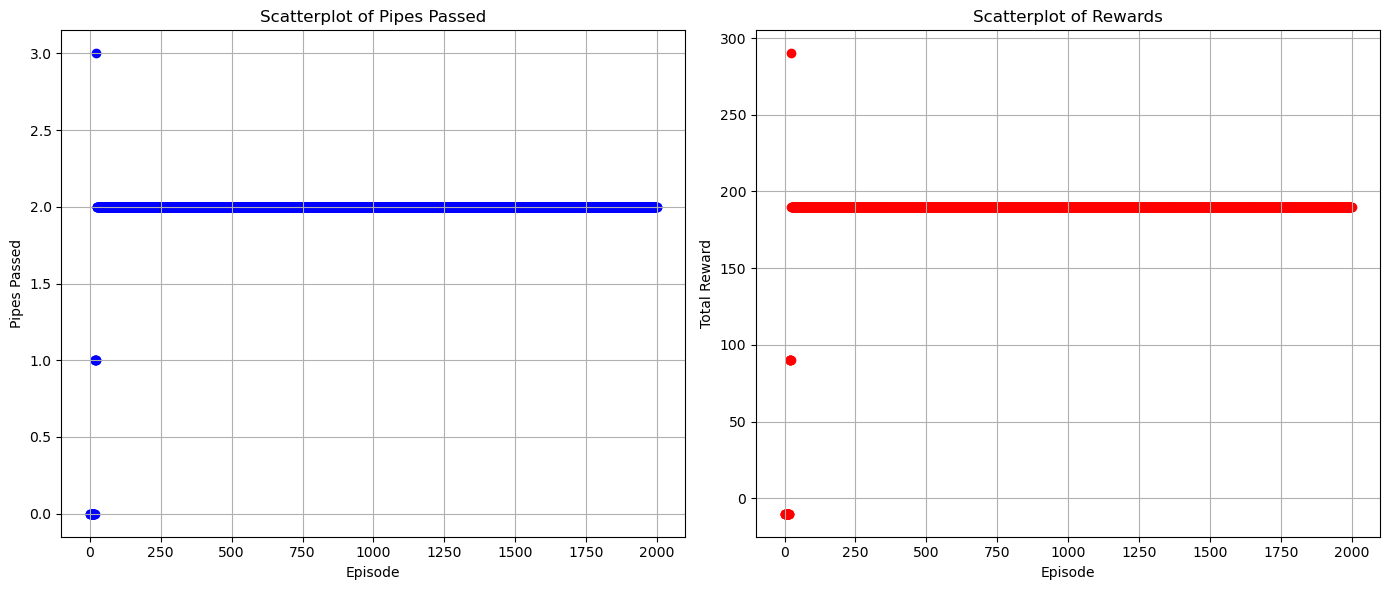

In [51]:
df = pd.DataFrame({"Reward": list_rewards, "Pipes": list_pipes})
df["Pipe State"]="Static Pipes"
df["Index"] = df.index

# df["Pipes"].max()
# print(df.loc[df["Pipes"]==df["Pipes"].max()])

# Scatterplots erstellen
plt.figure(figsize=(14, 6))

# Scatterplot für Pipes
plt.subplot(1, 2, 1)
plt.scatter(df['Index'], df['Pipes'], color='blue')
plt.title('Scatterplot of Pipes Passed')
plt.xlabel('Episode')
plt.ylabel('Pipes Passed')
plt.grid(True)

# Scatterplot für Rewards
plt.subplot(1, 2, 2)
plt.scatter(df['Index'], df['Reward'], color='red')
plt.title('Scatterplot of Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)

plt.tight_layout()
plt.show()

### Variable Pipes

#### Env and Agent

In [52]:
list_rewards=[]
list_pipes=[]

class FlappyBirdEnv(gym.Env):
    metadata = {'render_modes': ['human']}
    
    def __init__(self):
        super(FlappyBirdEnv, self).__init__()
        self.screen_width = 288
        self.screen_height = 512
        self.pipe_gap = 200
        self.bird_y = self.screen_height // 2
        self.bird_x = self.screen_width // 4
        self.gravity = 1
        self.jump_strength = -10
        self.pipe_width = 50
        self.pipe_velocity = -5
        self.pipe_x = self.screen_width  # Static x-position for pipes
        
        self.action_space = spaces.Discrete(2)  # 0: No flap, 1: Flap
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0, 0], dtype=np.float32),
            high=np.array([self.screen_width, self.screen_height, self.screen_width, self.screen_height], dtype=np.float32)
        )
        
        self.screen = None
        self.clock = None
        self.done = False
        self.bird_vel_y = 0
        self.score = 0
        self.pipes = []
        self.passed_pipes = 0
        self.seed_value = 42  # Seed für reproduzierbare Rohre
        
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.bird_y = self.screen_height // 2
        self.bird_x = self.screen_width // 4
        self.bird_vel_y = 0
        self.done = False
        self.score = 0
        self.passed_pipes = 0
        self._set_seed()
        self.pipes = self._create_fixed_pipes()
        return self._get_observation(), {}
    
    def step(self, action):
        if action == 1:
            self.bird_vel_y = self.jump_strength
        self.bird_vel_y += self.gravity
        self.bird_y += self.bird_vel_y
        
        if self.bird_y < 0:
            self.bird_y = 0
            self.done = True
        if self.bird_y > self.screen_height:
            self.bird_y = self.screen_height
            self.done = True
        
        self._move_pipes()
        self._check_collision()
        
        reward = 0.1  # Pro Zeiteinheit
        
        if self._passed_pipe():
            reward += 1
            self.passed_pipes += 1
            print(f"Pipe passed! Total pipes passed: {self.passed_pipes}")
        
        if self.done:
            reward -= 1
        
        observation = self._get_observation()
        info = {'pipe_count': self.passed_pipes}
        return observation, reward, self.done, False, info
    
    def render(self, mode='human'):
        if self.screen is None:
            pygame.init()
            self.screen = pygame.display.set_mode((self.screen_width, self.screen_height))
            self.clock = pygame.time.Clock()
        
        self.screen.fill((0, 0, 255))
        pygame.draw.circle(self.screen, (255, 255, 0), (self.bird_x, self.bird_y), 20)
        
        for pipe in self.pipes:
            pygame.draw.rect(self.screen, (0, 255, 0), pipe['top'])
            pygame.draw.rect(self.screen, (0, 255, 0), pipe['bottom'])
        
        pygame.display.flip()
        self.clock.tick(30)
    
    def close(self):
        if self.screen is not None:
            pygame.quit()
            self.screen = None
    
    def _create_fixed_pipes(self):
        # Create fixed pipes positions
        pipes = []
        x_positions = [self.screen_width + i * 3 * self.pipe_width for i in range(5)]
        for x in x_positions:
            gap_start = random.randint(0, self.screen_height - self.pipe_gap)
            top_rect = pygame.Rect(x, 0, self.pipe_width, gap_start)
            bottom_rect = pygame.Rect(x, gap_start + self.pipe_gap, self.pipe_width, self.screen_height)
            pipes.append({'top': top_rect, 'bottom': bottom_rect, 'passed': False})
        return pipes
    
    def _move_pipes(self):
        for pipe in self.pipes:
            pipe['top'].x += self.pipe_velocity
            pipe['bottom'].x += self.pipe_velocity
        
        if self.pipes and self.pipes[0]['top'].x < -self.pipe_width:
            self.pipes.pop(0)
        
        if not self.pipes or self.pipes[-1]['top'].x < self.screen_width - 3 * self.pipe_width:
            self.pipes.append(self._create_pipe())
    
    def _check_collision(self):
        if self.bird_y >= self.screen_height or self.bird_y <= 0:
            self.done = True
            return
        
        bird_rect = pygame.Rect(self.bird_x, self.bird_y, 20, 20)
        for pipe in self.pipes:
            if bird_rect.colliderect(pipe['top']) or bird_rect.colliderect(pipe['bottom']):
                self.done = True
                return
    
    def _get_observation(self):
        pipe = self.pipes[0]
        return np.array([self.bird_x, self.bird_y, pipe['top'].x, pipe['top'].bottom], dtype=np.float32)

    def _passed_pipe(self):
        for pipe in self.pipes:
            if not pipe['passed'] and pipe['top'].x < self.bird_x:
                pipe['passed'] = True
                return True
        return False
    
    def _set_seed(self):
        random.seed(self.seed_value)
        np.random.seed(self.seed_value)

class QLearningAgent:
    def __init__(self, state_bins, num_actions, alpha=0.1, gamma=0.99, epsilon=0.1, observation_space=None):
        self.state_bins = state_bins
        self.num_actions = num_actions
        self.alpha = alpha  # Lernrate
        self.gamma = gamma  # Diskontierungsfaktor
        self.epsilon = epsilon  # Epsilon für epsilon-greedy Policy
        self.q_table = np.zeros((*state_bins, num_actions))
        self.observation_space = observation_space

    def discretize(self, state):
        state_indices = []
        for i in range(len(state)):
            idx = np.digitize(state[i], np.linspace(0, self.observation_space.high[i], self.state_bins[i])) - 1
            idx = min(self.state_bins[i] - 1, max(0, idx))  # Ensure idx is within bounds
            state_indices.append(idx)
        return tuple(state_indices)

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(range(self.num_actions))  # Zufällige Aktion (explore)
        else:
            return np.argmax(self.q_table[state])  # Beste Aktion (exploit)

    def update(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.gamma * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.alpha * td_error

    def train(self, env, num_episodes):
        total_rewards = []
        pipes_passed = []
        for episode in range(num_episodes):
            state, _ = env.reset()
            state = self.discretize(state)
            done = False
            episode_reward = 0
            episode_pipes = 0
            while not done:
                action = self.choose_action(state)
                next_state, reward, done, truncated, info = env.step(action)
                next_state = self.discretize(next_state)
                self.update(state, action, reward, next_state)
                state = next_state
                episode_reward += reward
                episode_pipes = info.get('pipe_count', episode_pipes)
            total_rewards.append(episode_reward)
            pipes_passed.append(episode_pipes)
            print(f"Episode {episode + 1}/{num_episodes} completed, Reward: {episode_reward}, Pipes Passed: {episode_pipes}")
            list_pipes.append(episode_pipes)
            list_rewards.append(episode_reward)
        return total_rewards, pipes_passed

    def evaluate(self, env, num_episodes=10):
        evaluation_rewards = []
        evaluation_pipes_passed = []
        for episode in range(num_episodes):
            state, _ = env.reset()
            state = self.discretize(state)
            done = False
            episode_reward = 0
            episode_pipes = 0
            while not done:
                action = np.argmax(self.q_table[state])
                next_state, reward, done, truncated, info = env.step(action)
                next_state = self.discretize(next_state)
                state = next_state
                episode_reward += reward
                episode_pipes = info.get('pipe_count', episode_pipes)
            evaluation_rewards.append(episode_reward)
            evaluation_pipes_passed.append(episode_pipes)
            print(f"Evaluation Episode {episode + 1}/{num_episodes} completed, Reward: {episode_reward}, Pipes Passed: {episode_pipes}")
        return evaluation_rewards, evaluation_pipes_passed

    def save(self, filename):
        np.save(filename, self.q_table)
        
    def load(self, filename):
        self.q_table = np.load(filename)

# Verwendung der benutzerdefinierten Umgebung
env = FlappyBirdEnv()
state_bins = (10, 10, 10, 10)  # Diskretisierung in 10 Bins pro Zustandsdimension
num_actions = env.action_space.n

agent = QLearningAgent(state_bins=state_bins, num_actions=num_actions, observation_space=env.observation_space)
#number_episodes = 1000  # Beispielwert, setze dies entsprechend deiner Bedürfnisse
rewards, pipes_passed = agent.train(env, num_episodes=number_episodes)

Episode 1/2000 completed, Reward: 1.3000000000000007, Pipes Passed: 0
Episode 2/2000 completed, Reward: 3.000000000000002, Pipes Passed: 0
Episode 3/2000 completed, Reward: 3.000000000000002, Pipes Passed: 0
Episode 4/2000 completed, Reward: 3.000000000000002, Pipes Passed: 0
Episode 5/2000 completed, Reward: 3.000000000000002, Pipes Passed: 0
Episode 6/2000 completed, Reward: 3.000000000000002, Pipes Passed: 0
Episode 7/2000 completed, Reward: 3.000000000000002, Pipes Passed: 0
Episode 8/2000 completed, Reward: 3.000000000000002, Pipes Passed: 0
Episode 9/2000 completed, Reward: 3.000000000000002, Pipes Passed: 0
Episode 10/2000 completed, Reward: 3.000000000000002, Pipes Passed: 0
Episode 11/2000 completed, Reward: 3.000000000000002, Pipes Passed: 0
Episode 12/2000 completed, Reward: 3.000000000000002, Pipes Passed: 0
Episode 13/2000 completed, Reward: 3.000000000000002, Pipes Passed: 0
Episode 14/2000 completed, Reward: 3.000000000000002, Pipes Passed: 0
Episode 15/2000 completed, R

#### Plotten

In [53]:
df_1 = pd.DataFrame({"Reward": list_rewards, "Pipes": list_pipes})
df_1["Pipe State"]="Variable Pipes"
df_1["Index"] = df_1.index
df_combined = pd.concat([df, df_1], ignore_index=True)
df_combined

,Reward,Pipes,Pipe State,Index
0,-10.0,0,Static Pipes,0
1,-10.0,0,Static Pipes,1
2,-10.0,0,Static Pipes,2
3,-10.0,0,Static Pipes,3
4,-10.0,0,Static Pipes,4
...,...,...,...,...
3995,3.0,0,Variable Pipes,1995
3996,3.0,0,Variable Pipes,1996
3997,3.0,0,Variable Pipes,1997
3998,3.0,0,Variable Pipes,1998


<Axes: xlabel='Index', ylabel='Pipes'>

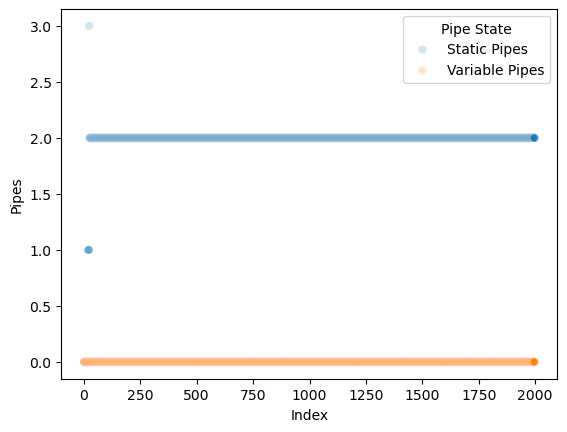

In [54]:
import seaborn as sns
sns.scatterplot(data=df_combined, x="Index", y="Pipes", hue="Pipe State", alpha=0.2)

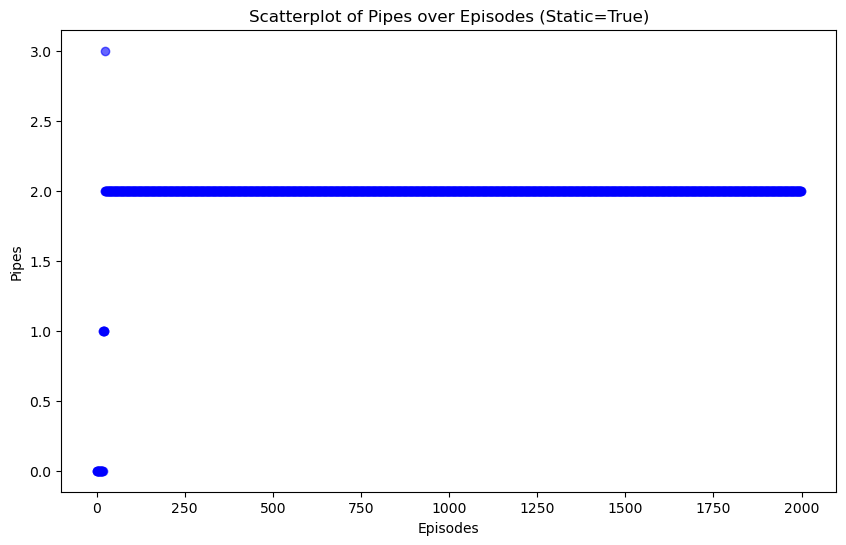

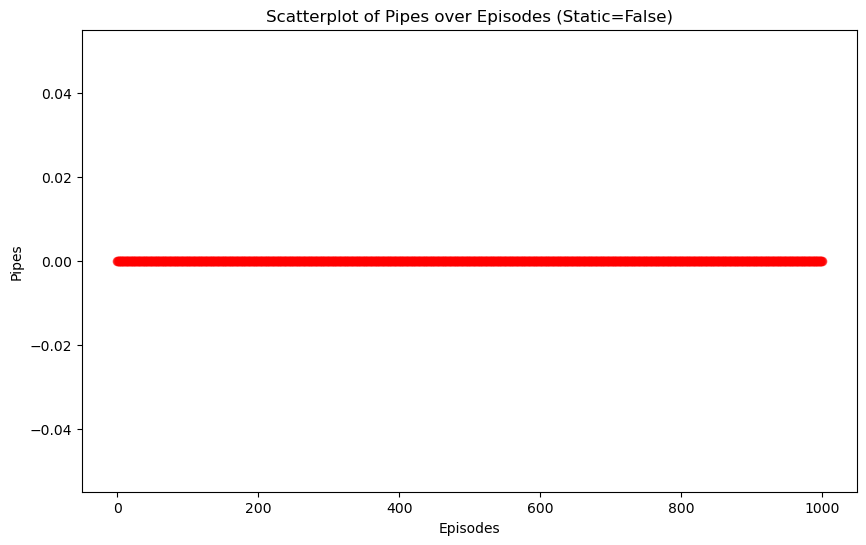

In [19]:
# Scatterplot für Static = True
df_true = df_combined[df_combined['Static'] == "True"]
plt.figure(figsize=(10, 6))
plt.scatter(df_true['Index'], df_true['Pipes'], color='b', alpha=0.6)
plt.title('Scatterplot of Pipes over Episodes (Static=True)')
plt.xlabel('Episodes')
plt.ylabel('Pipes')
plt.show()

# Scatterplot für Static = False
df_false = df_combined[df_combined['Static'] == "False"]
plt.figure(figsize=(10, 6))
plt.scatter(df_false['Index'], df_false['Pipes'], color='r', alpha=0.6)
plt.title('Scatterplot of Pipes over Episodes (Static=False)')
plt.xlabel('Episodes')
plt.ylabel('Pipes')
plt.show()

In [20]:
df_combined

,Reward,Pipes,Static,Index
0,-10.0,0,True,0
1,-10.0,0,True,1
2,-10.0,0,True,2
3,-10.0,0,True,3
4,-10.0,0,True,4
...,...,...,...,...
2995,3.0,0,False,995
2996,3.0,0,False,996
2997,3.0,0,False,997
2998,3.0,0,False,998


In [ ]:


df_hyper = pd.melt(df_hyper, var_name='attribute', value_name='pipe')
df_hyper["episode"]= repeated_list
df_hyper

In [14]:
def run_episode(env, agent, render=True):
    state, _ = env.reset()
    state = agent.discretize(state)
    done = False
    total_reward = 0
    while not done:
        action = np.argmax(agent.q_table[state])  # Wähle die beste Aktion basierend auf der Q-Tabelle
        next_state, reward, done, _, info = env.step(action)
        next_state = agent.discretize(next_state)
        state = next_state
        total_reward += reward
        if render:
            env.render()
    env.close()
    print(f"Episode finished. Total reward: {total_reward}, Pipes passed: {info['pipe_count']}")

# Führe eine Episode aus
run_episode(env, agent, render=True)

Episode finished. Total reward: 190, Pipes passed: 2


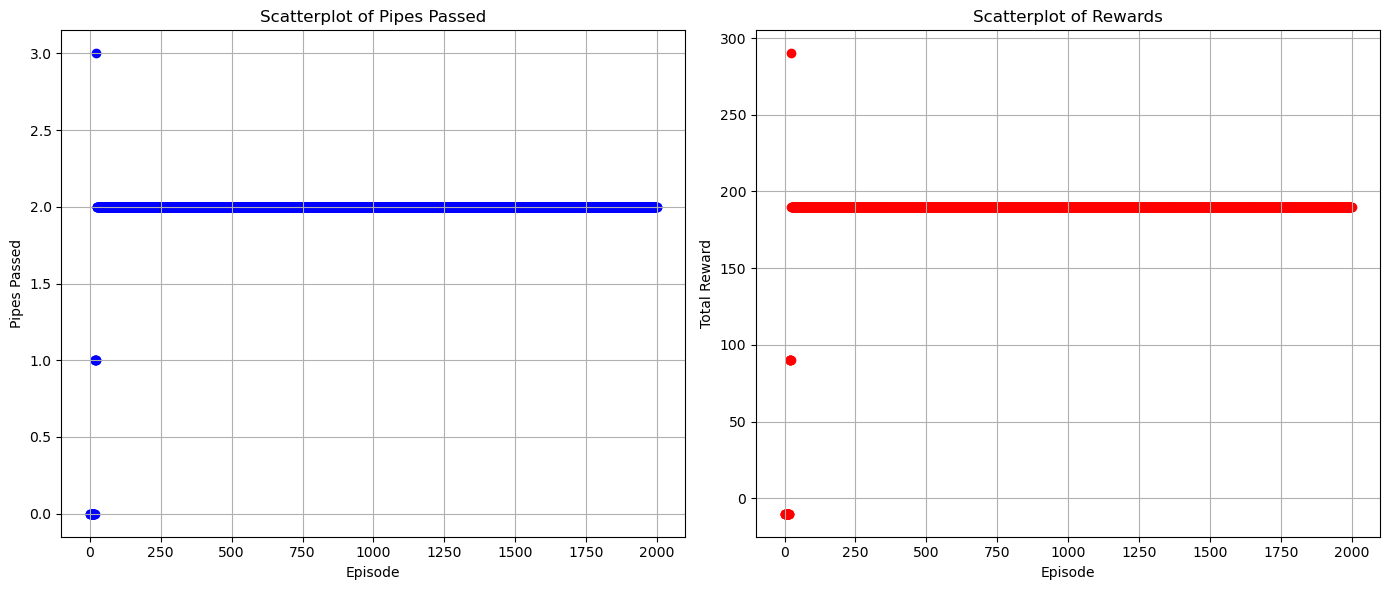

In [16]:
df = pd.DataFrame({"Reward": list_rewards, "Pipes": list_pipes})
df["Index"] = df.index

# df["Pipes"].max()
# print(df.loc[df["Pipes"]==df["Pipes"].max()])

# Scatterplots erstellen
plt.figure(figsize=(14, 6))

# Scatterplot für Pipes
plt.subplot(1, 2, 1)
plt.scatter(df['Index'], df['Pipes'], color='blue')
plt.title('Scatterplot of Pipes Passed')
plt.xlabel('Episode')
plt.ylabel('Pipes Passed')
plt.grid(True)

# Scatterplot für Rewards
plt.subplot(1, 2, 2)
plt.scatter(df['Index'], df['Reward'], color='red')
plt.title('Scatterplot of Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)

plt.tight_layout()
plt.show()

In [26]:
# Laden der Q-Tabelle und Ausführen einer Episode
agent.load('trained_q_table.npy')

def run_episode(env, agent, render=True):
    state, _ = env.reset()
    state = agent.discretize(state)
    done = False
    total_reward = 0
    while not done:
        action = np.argmax(agent.q_table[state])  # Wähle die beste Aktion basierend auf der Q-Tabelle
        next_state, reward, done, _, info = env.step(action)
        next_state = agent.discretize(next_state)
        state = next_state
        total_reward += reward
        if render:
            env.render()
    env.close()
    print(f"Episode finished. Total reward: {total_reward}, Pipes passed: {info['pipe_count']}")

# Führe eine Episode aus
run_episode(env, agent, render=True)

Episode finished. Total reward: -10, Pipes passed: 0


# Andere Learningansatz

## Env

In [ ]:
class FlappyBirdEnv(gym.Env):
    metadata = {'render_modes': ['human']}
    
    def __init__(self):
        super(FlappyBirdEnv, self).__init__()
        self.screen_width = 288
        self.screen_height = 512
        self.pipe_gap = 200
        self.bird_y = self.screen_height // 2
        self.bird_x = self.screen_width // 4
        self.gravity = 1
        self.jump_strength = -10
        self.pipe_width = 50
        self.pipe_velocity = -5
        self.pipe_x = self.screen_width  # Static x-position for pipes
        
        self.action_space = spaces.Discrete(2)  # 0: No flap, 1: Flap
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0, 0], dtype=np.float32),
            high=np.array([self.screen_width, self.screen_height, self.screen_width, self.screen_height], dtype=np.float32)
        )
        
        self.screen = None
        self.clock = None
        self.done = False
        self.bird_vel_y = 0
        self.score = 0
        self.pipes = []
        self.passed_pipes = 0
        self.seed_value = 42  # Seed für reproduzierbare Rohre
        
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.bird_y = self.screen_height // 2
        self.bird_x = self.screen_width // 4
        self.bird_vel_y = 0
        self.done = False
        self.score = 0
        self.passed_pipes = 0
        self._set_seed()
        self.pipes = self._create_fixed_pipes()
        return self._get_observation(), {}
    
    def step(self, action):
        if action == 1:
            self.bird_vel_y = self.jump_strength
        self.bird_vel_y += self.gravity
        self.bird_y += self.bird_vel_y
        
        if self.bird_y < 0:
            self.bird_y = 0
            self.done = True
        if self.bird_y > self.screen_height:
            self.bird_y = self.screen_height
            self.done = True
        
        self._move_pipes()
        self._check_collision()
        
        reward = 0.1  # Pro Zeiteinheit
        
        if self._passed_pipe():
            reward += 1
            self.passed_pipes += 1
            print(f"Pipe passed! Total pipes passed: {self.passed_pipes}")
        
        if self.done:
            reward -= 1
        
        observation = self._get_observation()
        info = {'pipe_count': self.passed_pipes}
        return observation, reward, self.done, False, info
    
    def render(self, mode='human'):
        if self.screen is None:
            pygame.init()
            self.screen = pygame.display.set_mode((self.screen_width, self.screen_height))
            self.clock = pygame.time.Clock()
        
        self.screen.fill((0, 0, 255))
        pygame.draw.circle(self.screen, (255, 255, 0), (self.bird_x, self.bird_y), 20)
        
        for pipe in self.pipes:
            pygame.draw.rect(self.screen, (0, 255, 0), pipe['top'])
            pygame.draw.rect(self.screen, (0, 255, 0), pipe['bottom'])
        
        pygame.display.flip()
        self.clock.tick(30)
    
    def close(self):
        if self.screen is not None:
            pygame.quit()
            self.screen = None
    
    def _create_fixed_pipes(self):
        # Create fixed pipes positions
        pipes = []
        x_positions = [self.screen_width + i * 3 * self.pipe_width for i in range(5)]
        for x in x_positions:
            gap_start = random.randint(0, self.screen_height - self.pipe_gap)
            top_rect = pygame.Rect(x, 0, self.pipe_width, gap_start)
            bottom_rect = pygame.Rect(x, gap_start + self.pipe_gap, self.pipe_width, self.screen_height)
            pipes.append({'top': top_rect, 'bottom': bottom_rect, 'passed': False})
        return pipes
    
    def _move_pipes(self):
        for pipe in self.pipes:
            pipe['top'].x += self.pipe_velocity
            pipe['bottom'].x += self.pipe_velocity
        
        if self.pipes and self.pipes[0]['top'].x < -self.pipe_width:
            self.pipes.pop(0)
        
        if not self.pipes or self.pipes[-1]['top'].x < self.screen_width - 3 * self.pipe_width:
            self.pipes.append(self._create_pipe())
    
    def _check_collision(self):
        if self.bird_y >= self.screen_height or self.bird_y <= 0:
            self.done = True
            return
        
        bird_rect = pygame.Rect(self.bird_x, self.bird_y, 20, 20)
        for pipe in self.pipes:
            if bird_rect.colliderect(pipe['top']) or bird_rect.colliderect(pipe['bottom']):
                self.done = True
                return
    
    def _get_observation(self):
        pipe = self.pipes[0]
        return np.array([self.bird_x, self.bird_y, pipe['top'].x, pipe['top'].bottom], dtype=np.float32)

    def _passed_pipe(self):
        for pipe in self.pipes:
            if not pipe['passed'] and pipe['top'].x < self.bird_x:
                pipe['passed'] = True
                return True
        return False
    
    def _set_seed(self):
        random.seed(self.seed_value)
        np.random.seed(self.seed_value)

## Learning Algorithm

In [ ]:
list_rewards=[]
list_pipes=[]



class QLearningAgent:
    def __init__(self, state_bins, num_actions, alpha=0.1, gamma=0.99, epsilon=0.1, observation_space=None):
        self.state_bins = state_bins
        self.num_actions = num_actions
        self.alpha = alpha  # Lernrate
        self.gamma = gamma  # Diskontierungsfaktor
        self.epsilon = epsilon  # Epsilon für epsilon-greedy Policy
        self.q_table = np.zeros((*state_bins, num_actions))
        self.observation_space = observation_space

    def discretize(self, state):
        state_indices = []
        for i in range(len(state)):
            idx = np.digitize(state[i], np.linspace(0, self.observation_space.high[i], self.state_bins[i])) - 1
            idx = min(self.state_bins[i] - 1, max(0, idx))  # Ensure idx is within bounds
            state_indices.append(idx)
        return tuple(state_indices)

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(range(self.num_actions))  # Zufällige Aktion (explore)
        else:
            return np.argmax(self.q_table[state])  # Beste Aktion (exploit)

    def update(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.gamma * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.alpha * td_error

    def train(self, env, num_episodes):
        total_rewards = []
        pipes_passed = []
        for episode in range(num_episodes):
            state, _ = env.reset()
            state = self.discretize(state)
            done = False
            episode_reward = 0
            episode_pipes = 0
            while not done:
                action = self.choose_action(state)
                next_state, reward, done, truncated, info = env.step(action)
                next_state = self.discretize(next_state)
                self.update(state, action, reward, next_state)
                state = next_state
                episode_reward += reward
                episode_pipes = info.get('pipe_count', episode_pipes)
            total_rewards.append(episode_reward)
            pipes_passed.append(episode_pipes)
            print(f"Episode {episode + 1}/{num_episodes} completed, Reward: {episode_reward}, Pipes Passed: {episode_pipes}")
            list_pipes.append(episode_pipes)
            list_rewards.append(episode_reward)
        return total_rewards, pipes_passed

    def evaluate(self, env, num_episodes=10):
        evaluation_rewards = []
        evaluation_pipes_passed = []
        for episode in range(num_episodes):
            state, _ = env.reset()
            state = self.discretize(state)
            done = False
            episode_reward = 0
            episode_pipes = 0
            while not done:
                action = np.argmax(self.q_table[state])
                next_state, reward, done, truncated, info = env.step(action)
                next_state = self.discretize(next_state)
                state = next_state
                episode_reward += reward
                episode_pipes = info.get('pipe_count', episode_pipes)
            evaluation_rewards.append(episode_reward)
            evaluation_pipes_passed.append(episode_pipes)
            print(f"Evaluation Episode {episode + 1}/{num_episodes} completed, Reward: {episode_reward}, Pipes Passed: {episode_pipes}")
        return evaluation_rewards, evaluation_pipes_passed

    def save(self, filename):
        np.save(filename, self.q_table)
        
    def load(self, filename):
        self.q_table = np.load(filename)

# Verwendung der benutzerdefinierten Umgebung
env = FlappyBirdEnv()
state_bins = (10, 10, 10, 10)  # Diskretisierung in 10 Bins pro Zustandsdimension
num_actions = env.action_space.n

agent = QLearningAgent(state_bins=state_bins, num_actions=num_actions, observation_space=env.observation_space)
#number_episodes = 1000  # Beispielwert, setze dies entsprechend deiner Bedürfnisse
rewards, pipes_passed = agent.train(env, num_episodes=number_episodes)

# Basis Environment

In [5]:
import numpy as np
import random
import gym
from gym import spaces
import pygame

class FlappyBirdEnv(gym.Env):
    metadata = {'render_modes': ['human']}
    
    def __init__(self):
        super(FlappyBirdEnv, self).__init__()
        self.screen_width = 288
        self.screen_height = 512
        self.pipe_gap = 200
        self.bird_y = self.screen_height // 2
        self.bird_x = self.screen_width // 4
        self.gravity = 1
        self.jump_strength = -10
        self.pipe_width = 50
        self.pipe_velocity = -5
        self.pipe_x = self.screen_width  # Static x-position for pipes
        
        self.action_space = spaces.Discrete(2)  # 0: No flap, 1: Flap
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0, 0], dtype=np.float32),
            high=np.array([self.screen_width, self.screen_height, self.screen_width, self.screen_height], dtype=np.float32)
        )
        
        self.screen = None
        self.clock = None
        self.done = False
        self.bird_vel_y = 0
        self.score = 0
        self.pipes = []
        self.passed_pipes = 0
        self.seed_value = 42  # Seed für reproduzierbare Rohre
        
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.bird_y = self.screen_height // 2
        self.bird_x = self.screen_width // 4
        self.bird_vel_y = 0
        self.done = False
        self.score = 0
        self.passed_pipes = 0
        self._set_seed()
        self.pipes = self._create_fixed_pipes()
        return self._get_observation(), {}
    
    def step(self, action):
        if action == 1:
            self.bird_vel_y = self.jump_strength
        self.bird_vel_y += self.gravity
        self.bird_y += self.bird_vel_y
        
        if self.bird_y < 0:
            self.bird_y = 0
            self.done = True
        if self.bird_y > self.screen_height:
            self.bird_y = self.screen_height
            self.done = True
        
        self._move_pipes()
        self._check_collision()
        
        reward = 0.1  # Pro Zeiteinheit
        
        if self._passed_pipe():
            reward += 1
            self.passed_pipes += 1
            print(f"Pipe passed! Total pipes passed: {self.passed_pipes}")
        
        if self.done:
            reward -= 1
        
        observation = self._get_observation()
        info = {'pipe_count': self.passed_pipes}
        return observation, reward, self.done, False, info
    
    def render(self, mode='human'):
        if self.screen is None:
            pygame.init()
            self.screen = pygame.display.set_mode((self.screen_width, self.screen_height))
            self.clock = pygame.time.Clock()
        
        self.screen.fill((0, 0, 255))
        pygame.draw.circle(self.screen, (255, 255, 0), (self.bird_x, self.bird_y), 20)
        
        for pipe in self.pipes:
            pygame.draw.rect(self.screen, (0, 255, 0), pipe['top'])
            pygame.draw.rect(self.screen, (0, 255, 0), pipe['bottom'])
        
        pygame.display.flip()
        self.clock.tick(30)
    
    def close(self):
        if self.screen is not None:
            pygame.quit()
            self.screen = None
    
    def _create_fixed_pipes(self):
        # Create fixed pipes positions
        pipes = []
        x_positions = [self.screen_width + i * 3 * self.pipe_width for i in range(5)]
        for x in x_positions:
            gap_start = random.randint(0, self.screen_height - self.pipe_gap)
            top_rect = pygame.Rect(x, 0, self.pipe_width, gap_start)
            bottom_rect = pygame.Rect(x, gap_start + self.pipe_gap, self.pipe_width, self.screen_height)
            pipes.append({'top': top_rect, 'bottom': bottom_rect, 'passed': False})
        return pipes
    
    def _move_pipes(self):
        for pipe in self.pipes:
            pipe['top'].x += self.pipe_velocity
            pipe['bottom'].x += self.pipe_velocity
        
        if self.pipes and self.pipes[0]['top'].x < -self.pipe_width:
            self.pipes.pop(0)
        
        if not self.pipes or self.pipes[-1]['top'].x < self.screen_width - 3 * self.pipe_width:
            self.pipes.append(self._create_pipe())
    
    def _check_collision(self):
        if self.bird_y >= self.screen_height or self.bird_y <= 0:
            self.done = True
            return
        
        bird_rect = pygame.Rect(self.bird_x, self.bird_y, 20, 20)
        for pipe in self.pipes:
            if bird_rect.colliderect(pipe['top']) or bird_rect.colliderect(pipe['bottom']):
                self.done = True
                return
    
    def _get_observation(self):
        pipe = self.pipes[0]
        return np.array([self.bird_x, self.bird_y, pipe['top'].x, pipe['top'].bottom], dtype=np.float32)

    def _passed_pipe(self):
        for pipe in self.pipes:
            if not pipe['passed'] and pipe['top'].x < self.bird_x:
                pipe['passed'] = True
                return True
        return False
    
    def _set_seed(self):
        random.seed(self.seed_value)
        np.random.seed(self.seed_value)

class QLearningAgent:
    def __init__(self, state_bins, num_actions, alpha=0.1, gamma=0.99, epsilon=0.1, observation_space=None):
        self.state_bins = state_bins
        self.num_actions = num_actions
        self.alpha = alpha  # Lernrate
        self.gamma = gamma  # Diskontierungsfaktor
        self.epsilon = epsilon  # Epsilon für epsilon-greedy Policy
        self.q_table = np.zeros((*state_bins, num_actions))
        self.observation_space = observation_space

    def discretize(self, state):
        state_indices = []
        for i in range(len(state)):
            idx = np.digitize(state[i], np.linspace(0, self.observation_space.high[i], self.state_bins[i])) - 1
            idx = min(self.state_bins[i] - 1, max(0, idx))  # Ensure idx is within bounds
            state_indices.append(idx)
        return tuple(state_indices)

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(range(self.num_actions))  # Zufällige Aktion (explore)
        else:
            return np.argmax(self.q_table[state])  # Beste Aktion (exploit)

    def update(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.gamma * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.alpha * td_error

    def train(self, env, num_episodes):
        total_rewards = []
        pipes_passed = []
        for episode in range(num_episodes):
            state, _ = env.reset()
            state = self.discretize(state)
            done = False
            episode_reward = 0
            episode_pipes = 0
            while not done:
                action = self.choose_action(state)
                next_state, reward, done, truncated, info = env.step(action)
                next_state = self.discretize(next_state)
                self.update(state, action, reward, next_state)
                state = next_state
                episode_reward += reward
                episode_pipes = info.get('pipe_count', episode_pipes)
            total_rewards.append(episode_reward)
            pipes_passed.append(episode_pipes)
            print(f"Episode {episode + 1}/{num_episodes} completed, Reward: {episode_reward}, Pipes Passed: {episode_pipes}")
        return total_rewards, pipes_passed

    def evaluate(self, env, num_episodes=10):
        evaluation_rewards = []
        evaluation_pipes_passed = []
        for episode in range(num_episodes):
            state, _ = env.reset()
            state = self.discretize(state)
            done = False
            episode_reward = 0
            episode_pipes = 0
            while not done:
                action = np.argmax(self.q_table[state])
                next_state, reward, done, truncated, info = env.step(action)
                next_state = self.discretize(next_state)
                state = next_state
                episode_reward += reward
                episode_pipes = info.get('pipe_count', episode_pipes)
            evaluation_rewards.append(episode_reward)
            evaluation_pipes_passed.append(episode_pipes)
            print(f"Evaluation Episode {episode + 1}/{num_episodes} completed, Reward: {episode_reward}, Pipes Passed: {episode_pipes}")
        return evaluation_rewards, evaluation_pipes_passed

    def save(self, filename):
        np.save(filename, self.q_table)
        
    def load(self, filename):
        self.q_table = np.load(filename)

# Verwendung der benutzerdefinierten Umgebung
env = FlappyBirdEnv()
state_bins = (10, 10, 10, 10)  # Diskretisierung in 10 Bins pro Zustandsdimension
num_actions = env.action_space.n

agent = QLearningAgent(state_bins=state_bins, num_actions=num_actions, observation_space=env.observation_space)
number_episodes = 1000  # Beispielwert, setze dies entsprechend deiner Bedürfnisse
rewards, pipes_passed = agent.train(env, num_episodes=number_episodes)


Episode 1/1000 completed, Reward: 1.3000000000000007, Pipes Passed: 0
Episode 2/1000 completed, Reward: 3.000000000000002, Pipes Passed: 0
Episode 3/1000 completed, Reward: 3.000000000000002, Pipes Passed: 0
Episode 4/1000 completed, Reward: 3.000000000000002, Pipes Passed: 0
Episode 5/1000 completed, Reward: 3.000000000000002, Pipes Passed: 0
Episode 6/1000 completed, Reward: 3.000000000000002, Pipes Passed: 0
Episode 7/1000 completed, Reward: 3.000000000000002, Pipes Passed: 0
Episode 8/1000 completed, Reward: 3.000000000000002, Pipes Passed: 0
Episode 9/1000 completed, Reward: 3.000000000000002, Pipes Passed: 0
Episode 10/1000 completed, Reward: 3.000000000000002, Pipes Passed: 0
Episode 11/1000 completed, Reward: 3.000000000000002, Pipes Passed: 0
Episode 12/1000 completed, Reward: 3.000000000000002, Pipes Passed: 0
Episode 13/1000 completed, Reward: 3.000000000000002, Pipes Passed: 0
Episode 14/1000 completed, Reward: 3.000000000000002, Pipes Passed: 0
Episode 15/1000 completed, R

# Q-Learning

## Registrieren der Environment

In [4]:
# Registrierung der Umgebung
gym.envs.registration.register(
    id='FlappyBird-v0',
    entry_point=FlappyBirdEnv,
    max_episode_steps=10000,
)

# Verwendung der benutzerdefinierten Umgebung
env = gym.make('FlappyBird-v0')

c:\Users\Katha\anaconda3\envs\RL\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment FlappyBird-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [5]:
# Reset der Umgebung
state, _ = env.reset()

# Render der Umgebung
done = False
while not done:
    action = env.action_space.sample()  # Zufällige Aktion
    state, reward, done, truncated, info = env.step(action)
    env.render()

env.close()

c:\Users\Katha\anaconda3\envs\RL\Lib\site-packages\gymnasium\utils\passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


## QLearning Agent

In [6]:
list_alpha = [0.01, 0.5]
list_gamma = [0.9, 1]
list_epsilon =[0.01,0.2]
class metrics:
    liste = []
    standard = 0
    name = ""
Alpha = metrics
Alpha.liste = [0.01, 0.5]
Alpha.standard = 0.1
Alpha.name = "alpha"
Gamma = metrics
Gamma.liste= [0.9, 0.99]
Gamma.standard = 0.99
Gamma.name = "gamma"
Epsilon = metrics
Epsilon.liste= [0.01,0.2]
Epsilon.standard = 0.1
Epsilon.name = "epsilon"

In [7]:
class QLearningAgent:
    def __init__(self, state_bins, num_actions, alpha=Alpha.standard, gamma= Gamma.standard, epsilon=Epsilon.standard, observation_space=None):
        self.state_bins = state_bins
        self.num_actions = num_actions
        self.alpha = alpha  # Lernrate
        self.gamma = gamma  # Diskontierungsfaktor
        self.epsilon = epsilon  # Epsilon für epsilon-greedy Policy
        self.q_table = np.zeros((*state_bins, num_actions))
        self.observation_space = observation_space

    def discretize(self, state):
        state_indices = []
        for i in range(len(state)):
            idx = np.digitize(state[i], np.linspace(0, self.observation_space.high[i], self.state_bins[i])) - 1
            state_indices.append(idx)
        return tuple(state_indices)

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(range(self.num_actions))  # Zufällige Aktion (explore)
        else:
            return np.argmax(self.q_table[state])  # Beste Aktion (exploit)

    def update(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.gamma * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.alpha * td_error

    def train(self, env, num_episodes):
        total_rewards = []
        pipes_passed = []
        for episode in range(num_episodes):
            state, _ = env.reset()
            state = self.discretize(state)
            done = False
            episode_reward = 0
            episode_pipes = 0
            while not done:
                action = self.choose_action(state)
                next_state, reward, done, truncated, info = env.step(action)
                next_state = self.discretize(next_state)
                self.update(state, action, reward, next_state)
                state = next_state
                episode_reward += reward
                episode_pipes = info.get('pipe_count', episode_pipes)  # Zählen der Pipes aus dem Info-Dictionary
            total_rewards.append(episode_reward)
            pipes_passed.append(episode_pipes)
            #print(f"Episode {episode + 1}/{num_episodes} completed, Reward: {episode_reward}, Pipes Passed: {episode_pipes}")
        return total_rewards, pipes_passed
    def evaluate(self, env, num_episodes=10):
        evaluation_rewards = []
        evaluation_pipes_passed = []
        for episode in range(num_episodes):
            state, _ = env.reset()
            state = self.discretize(state)
            done = False
            episode_reward = 0
            episode_pipes = 0
            while not done:
                action = np.argmax(self.q_table[state])  # Beste Aktion basierend auf der Q-Tabelle wählen
                next_state, reward, done, truncated, info = env.step(action)
                next_state = self.discretize(next_state)
                state = next_state
                episode_reward += reward
                episode_pipes = info.get('pipe_count', episode_pipes)
            evaluation_rewards.append(episode_reward)
            evaluation_pipes_passed.append(episode_pipes)
            #print(f"Evaluation Episode {episode + 1}/{num_episodes} completed, Reward: {episode_reward}, Pipes Passed: {episode_pipes}")
        return evaluation_rewards, evaluation_pipes_passed
    def save(self, filename):
        np.save(filename, self.q_table)
        
    def load(self, filename):
        self.q_table = np.load(filename)


# Verwendung der benutzerdefinierten Umgebung
env = FlappyBirdEnv()
state_bins = (10, 10, 10, 10)  # Diskretisierung in 10 Bins pro Zustandsdimension
num_actions = env.action_space.n

agent = QLearningAgent(state_bins=state_bins, num_actions=num_actions, observation_space=env.observation_space)
rewards, pipes_passed = agent.train(env, num_episodes=number_episodes)


In [8]:
#agent.save('models_qlearning/basis_')

In [10]:
#agent = QLearningAgent(state_bins=state_bins, num_actions=num_actions, observation_space=env.observation_space)
df_q_learing = pd.DataFrame()
#Alpha
# Beispiel für die Verwendung anderer Hyperparameter
for i in Alpha.liste:
    agent = QLearningAgent(
        state_bins=state_bins,
        num_actions=num_actions,
        alpha=i,
        gamma=Gamma.standard,
        epsilon=Epsilon.standard,
        observation_space=env.observation_space
    )

    nr_episodes = number_episodes  # Beispielwert für die Anzahl der Episoden
    rewards, pipes_passed = agent.train(env, num_episodes=nr_episodes)
    agent.save('models_qlearning/alpha_' + str(i))
    df_q_learing["alpha_rewards"+str(i)]=rewards
    df_q_learing["alpha_pipes"+str(i)]=pipes_passed
    

#Gamma
# Beispiel für die Verwendung anderer Hyperparameter
for i in Gamma.liste:
    agent = QLearningAgent(
        state_bins=state_bins,
        num_actions=num_actions,
        alpha=Alpha.standard,
        gamma=i,
        epsilon=Epsilon.standard,
        observation_space=env.observation_space
    )

    nr_episodes = number_episodes  # Beispielwert für die Anzahl der Episoden
    rewards, pipes_passed = agent.train(env, num_episodes=nr_episodes)
    agent.save('models_qlearning/gamma_' + str(i))
    df_q_learing["gamma_rewards"+str(i)]=rewards
    df_q_learing["gamma_pipes"+str(i)]=pipes_passed


    

#Epsilon
# Beispiel für die Verwendung anderer Hyperparameter
for i in Epsilon.liste:
    agent = QLearningAgent(
        state_bins=state_bins,
        num_actions=num_actions,
        alpha=Alpha.standard,
        gamma=Gamma.standard,
        epsilon=i,
        observation_space=env.observation_space
    )

    nr_episodes = number_episodes  # Beispielwert für die Anzahl der Episoden
    rewards, pipes_passed = agent.train(env, num_episodes=nr_episodes)
    agent.save('models_qlearning/epsilon_' + str(i))
    df_q_learing["epsilon_rewards"+str(i)]=rewards
    df_q_learing["epsilon_pipes"+str(i)]=pipes_passed

    


In [11]:
df_q_learing.to_csv("models_qlearning.train_progress.csv")


In [12]:
# Modell laden und evaluieren
agent.load('models_qlearning/q_table.npy')
eval_rewards, eval_pipes_passed = agent.evaluate(env)

print(f"Evaluation Rewards: {eval_rewards}")
print(f"Evaluation Pipes Passed: {eval_pipes_passed}")

FileNotFoundError: [Errno 2] No such file or directory: 'models_qlearning/q_table.npy'

## Plotten des Rewards

    Reward  Pipes  Index
81     -97      3     81


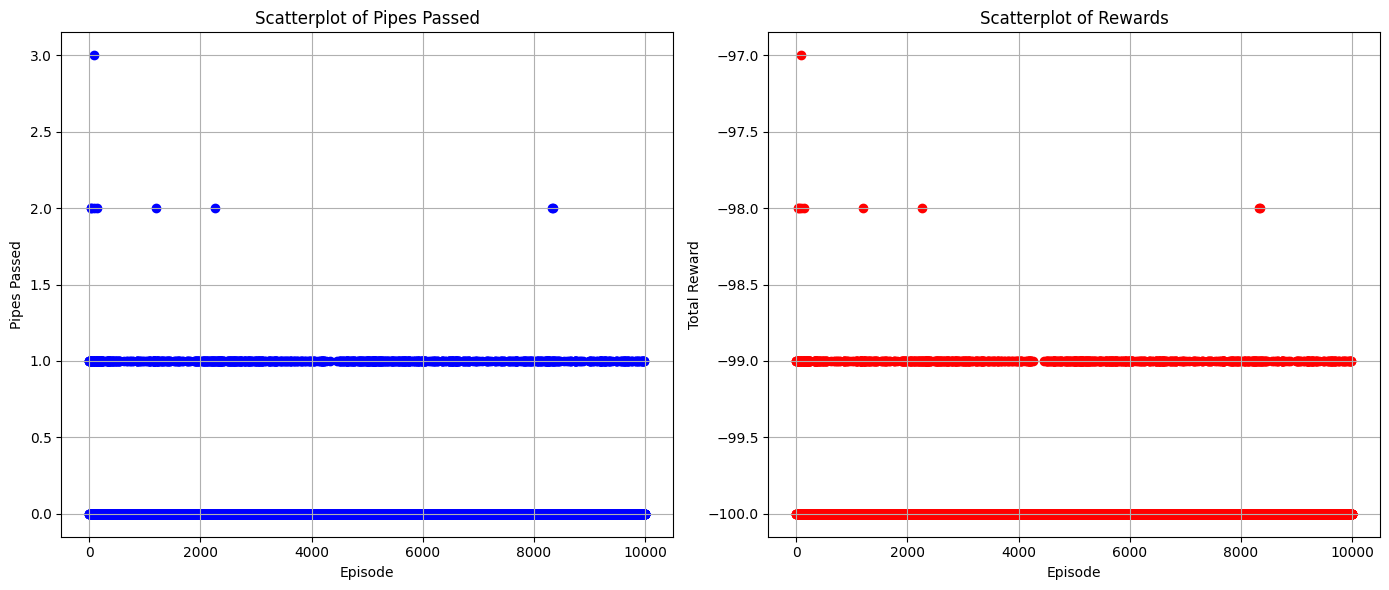

In [ ]:
df = pd.DataFrame({"Reward": rewards, "Pipes": pipes_passed})
df["Index"] = df.index

df["Pipes"].max()
print(df.loc[df["Pipes"]==df["Pipes"].max()])

# Scatterplots erstellen
plt.figure(figsize=(14, 6))

# Scatterplot für Pipes
plt.subplot(1, 2, 1)
plt.scatter(df['Index'], df['Pipes'], color='blue')
plt.title('Scatterplot of Pipes Passed')
plt.xlabel('Episode')
plt.ylabel('Pipes Passed')
plt.grid(True)

# Scatterplot für Rewards
plt.subplot(1, 2, 2)
plt.scatter(df['Index'], df['Reward'], color='red')
plt.title('Scatterplot of Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Modell anwenden und die Umgebung rendern
state, _ = env.reset()
state = agent.discretize(state)

done = False
while not done:
    action = agent.choose_action(state)
    next_state, reward, done, truncated, info = env.step(action)
    next_state = agent.discretize(next_state)
    env.render()
    state = next_state

env.close()

## Rewards des Testen

In [ ]:
# Nach dem Training das Modell 10 Mal evaluieren
evaluation_rewards, evaluation_pipes_passed = agent.evaluate(env, num_episodes=10)

# Ergebnisse in einer Liste speichern
results = list(zip(evaluation_rewards, evaluation_pipes_passed))

Evaluation Episode 1/10 completed, Reward: -100, Pipes Passed: 0
Evaluation Episode 2/10 completed, Reward: -100, Pipes Passed: 0
Evaluation Episode 3/10 completed, Reward: -100, Pipes Passed: 0
Evaluation Episode 4/10 completed, Reward: -100, Pipes Passed: 0
Evaluation Episode 5/10 completed, Reward: -100, Pipes Passed: 0
Evaluation Episode 6/10 completed, Reward: -99, Pipes Passed: 1
Evaluation Episode 7/10 completed, Reward: -99, Pipes Passed: 1
Evaluation Episode 8/10 completed, Reward: -100, Pipes Passed: 0
Evaluation Episode 9/10 completed, Reward: -100, Pipes Passed: 0
Evaluation Episode 10/10 completed, Reward: -100, Pipes Passed: 0


   Reward  Pipes  Index
5     -99      1      5
6     -99      1      6


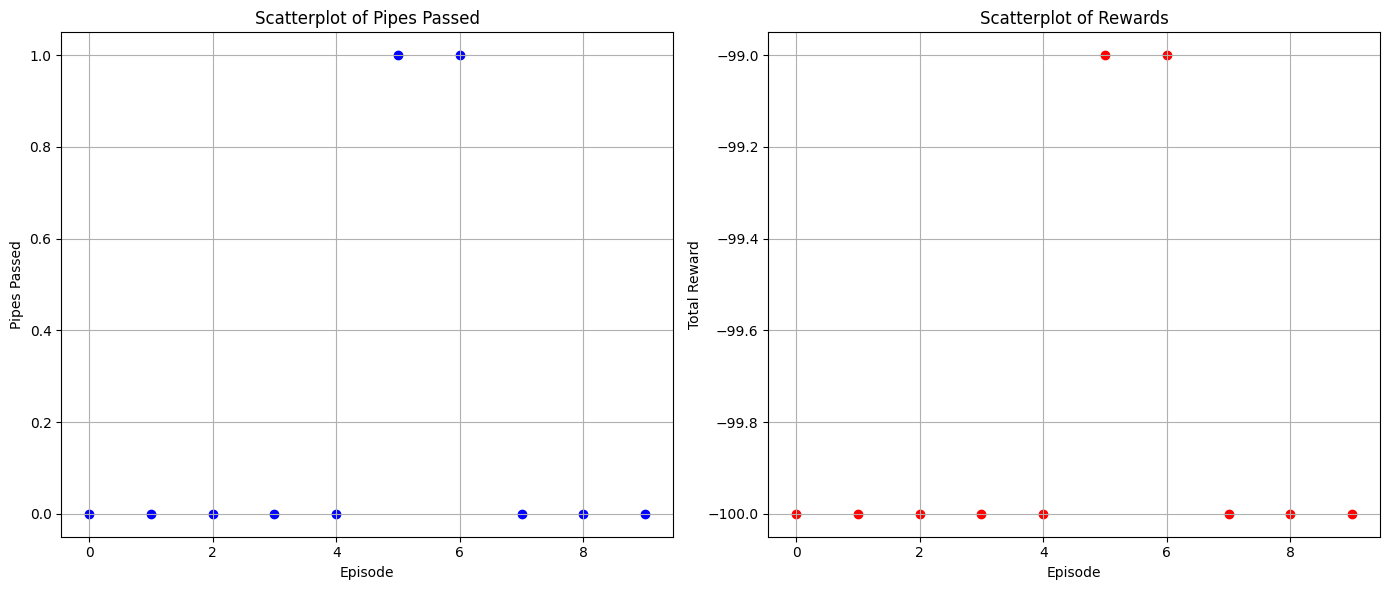

In [ ]:
df = pd.DataFrame({"Reward": evaluation_rewards, "Pipes": evaluation_pipes_passed})
df["Index"] = df.index

df["Pipes"].max()
print(df.loc[df["Pipes"]==df["Pipes"].max()])

# Scatterplots erstellen
plt.figure(figsize=(14, 6))

# Scatterplot für Pipes
plt.subplot(1, 2, 1)
plt.scatter(df['Index'], df['Pipes'], color='blue')
plt.title('Scatterplot of Pipes Passed')
plt.xlabel('Episode')
plt.ylabel('Pipes Passed')
plt.grid(True)

# Scatterplot für Rewards
plt.subplot(1, 2, 2)
plt.scatter(df['Index'], df['Reward'], color='red')
plt.title('Scatterplot of Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)

plt.tight_layout()
plt.show()

# Plotten des Hyperparametertunings

In [20]:
df_hyper = pd.read_csv("models_qlearning.train_progress.csv")
df_hyper

,Unnamed: 0,alpha_rewards0.01,alpha_pipes0.01,alpha_rewards0.2,alpha_pipes0.2,gamma_rewards0.01,gamma_pipes0.01,gamma_rewards0.2,gamma_pipes0.2,epsilon_rewards0.01,epsilon_pipes0.01,epsilon_rewards0.2,epsilon_pipes0.2
0,0,-100,0,-100,0,-100,1,-100,0,-100,0,-99,1
1,1,-100,0,-100,0,-99,1,-100,0,-100,0,-100,0
2,2,-100,0,-100,0,-100,0,-100,0,-100,0,-99,1
3,3,-99,1,-100,0,-99,1,-99,1,-100,0,-100,0
4,4,-100,0,-100,0,-100,0,-100,0,-100,0,-100,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,499995,-98,2,-100,0,-100,0,-100,0,-99,1,-100,0
499996,499996,-100,0,-99,1,-100,0,-100,0,-100,0,-100,0
499997,499997,-99,1,-100,0,-100,0,-100,0,-99,1,-100,0
499998,499998,-99,1,-100,0,-100,0,-100,0,-99,1,-99,1


In [36]:
# Erstellen einer Liste mit Zahlen von 1 bis 50000, die so oft wiederholt wird, bis die Liste 3500000 Elemente lang ist
repeated_list = list(range(1, 50001)) * (3000000 // 50000)

# Hinzufügen der verbleibenden Elemente, um genau 3500000 Elemente zu erreichen
remaining_elements = 3000000 % 50000
if remaining_elements > 0:
    repeated_list.extend(list(range(1, remaining_elements + 1)))

# Überprüfen der Länge der Liste, um zu bestätigen, dass sie 3500000 Elemente lang ist
print(len(repeated_list))  # Sollte 3500000 anzeigen

3000000


In [46]:
df_hyper = pd.read_csv("models_qlearning.train_progress.csv")
# Löschen aller Spalten, die das Wort 'reward' enthalten
columns_to_drop = [col for col in df_hyper.columns if 'reward' in col]
df_hyper = df_hyper.drop(columns=columns_to_drop)
df_hyper = df_hyper.drop(columns="Unnamed: 0")
#df_hyper["episode"]= repeated_list
# Umformen des DataFrames, sodass die Spaltennamen zu Attributen und die Werte in einer einzigen Spalte zusammengefasst werden
df_hyper = pd.melt(df_hyper, var_name='attribute', value_name='pipe')
df_hyper["episode"]= repeated_list
df_hyper

,attribute,pipe,episode
0,alpha_pipes0.01,0,1
1,alpha_pipes0.01,0,2
2,alpha_pipes0.01,0,3
3,alpha_pipes0.01,1,4
4,alpha_pipes0.01,0,5
...,...,...,...
2999995,epsilon_pipes0.2,0,49996
2999996,epsilon_pipes0.2,0,49997
2999997,epsilon_pipes0.2,0,49998
2999998,epsilon_pipes0.2,1,49999


<Axes: xlabel='episode', ylabel='value'>

c:\Users\Katha\anaconda3\envs\RL\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\Katha\anaconda3\envs\RL\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


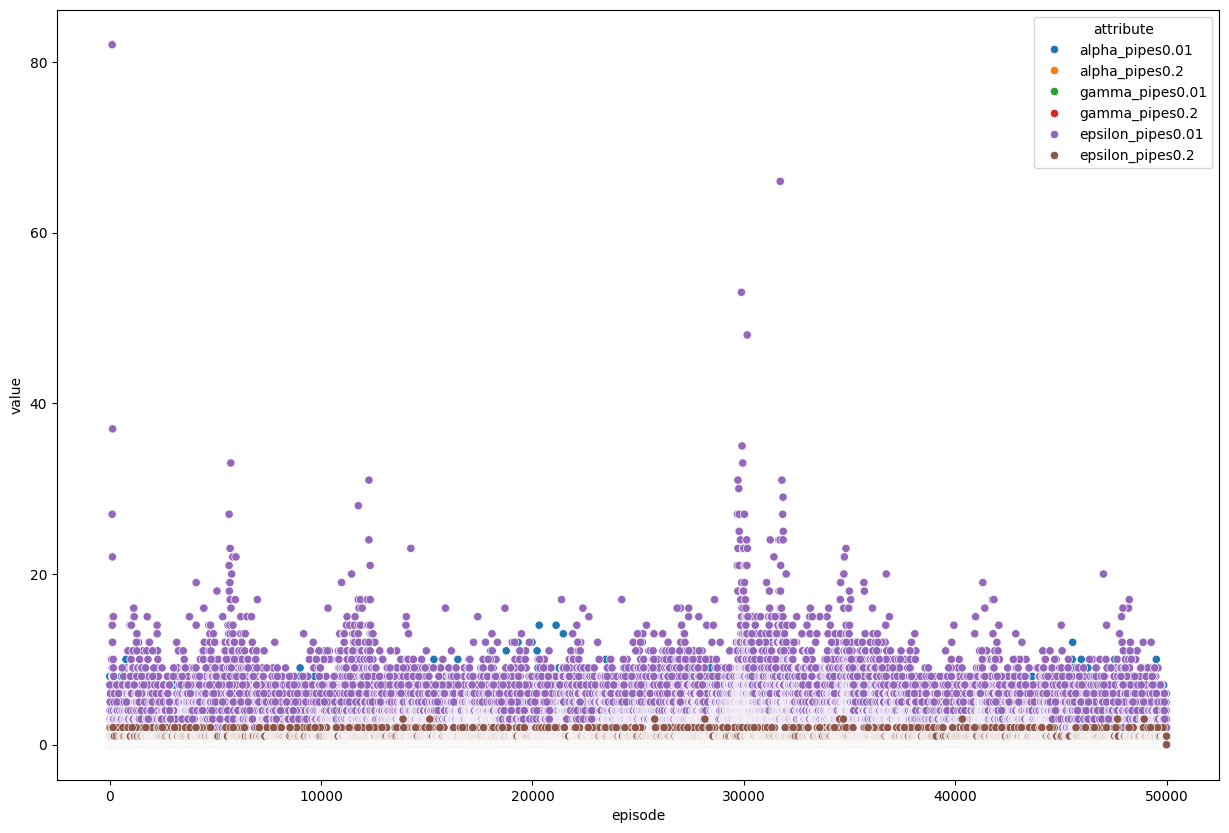

In [41]:
# Setting the size of the plot
plt.figure(figsize=(15, 10))

# Creating a scatter plot matrix
import seaborn as sns
sns.scatterplot(data=df_hyper, x="episode", y="pipe", hue="attribute")#, style="time")

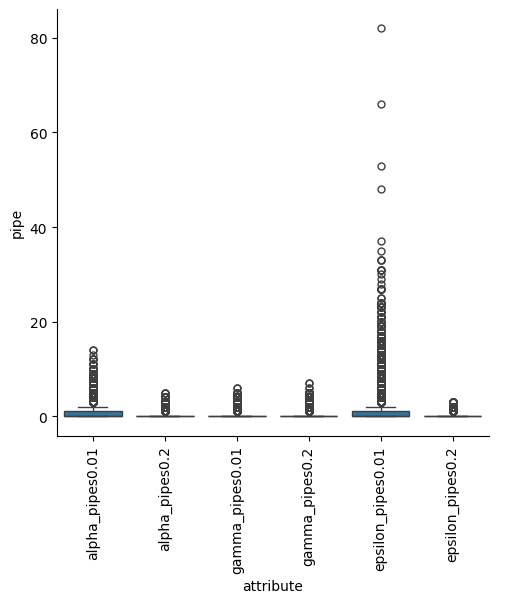

In [48]:
g = sns.catplot(data=df_hyper, x="attribute", y="pipe", kind="box")

# Drehe die Beschriftungen der x-Achse um 90 Grad
g.set_xticklabels(rotation=90)

# Zeige den Plot an
plt.show()

# PPO

## Erstellen des Modells

In [ ]:
class RewardPipeCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardPipeCallback, self).__init__(verbose)
        self.rewards = []
        self.pipe_counts = []
    
    def _on_step(self) -> bool:
        self.rewards.append(self.locals['rewards'])
        self.pipe_counts.append(self.locals['infos'][0]['pipe_count'])
        return True
    
    def _on_training_end(self) -> None:
        # Save the collected rewards and pipe counts to instance variables
        self.model.rewards = self.rewards
        self.model.pipe_counts = self.pipe_counts

# Überprüfe die Umgebung
env = FlappyBirdEnv()

# Erstelle den Callback
reward_pipe_callback = RewardPipeCallback()

# Trainiere den PPO Algorithmus mit dem Callback
model = PPO('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=number_episodes, callback=reward_pipe_callback)

# Speichere das trainierte Modell
model.save("ppo_flappybird")

# Lade das Modell und teste es
model = PPO.load("ppo_flappybird")

# Jetzt kannst du die gesammelten Belohnungen und Pipe-Zählungen nach dem Training auslesen
rewards = model.rewards
pipe_counts = model.pipe_counts

print(f"Gesammelte Belohnungen: {rewards}")
print(f"Gesammelte Pipe-Zählungen: {pipe_counts}")

episodes = 10  # Anzahl der Episoden zum Testen
pipe_counts_per_episode = []
list_rewards = []

for episode in range(episodes):
    obs = env.reset()[0]  # Extrahiere die Beobachtung aus dem Tuple
    total_pipes = 0
    total_reward = 0  # Summe der Belohnungen für diese Episode
    done = False
    while not done:
        action, _states = model.predict(obs)
        obs, reward, done, _, info = env.step(action)
        obs = obs  # Keine Extraktion mehr notwendig
        env.render()
        total_reward += reward  # Summiere die Belohnungen
        total_pipes = info['pipe_count']
    pipe_counts_per_episode.append(total_pipes)
    list_rewards.append(total_reward)  # Speichere die gesamte Belohnung
    print(f"Episode {episode + 1} beendet. Durchflogene Pipes: {total_pipes}, Belohnung: {total_reward}")

env.close()

print(f"Durchflogene Pipes pro Episode: {pipe_counts_per_episode}")
print(f"Belohnungen pro Episode: {list_rewards}")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 33.3     |
|    ep_rew_mean     | -100     |
| time/              |          |
|    fps             | 1811     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 34.6        |
|    ep_rew_mean          | -100        |
| time/                   |             |
|    fps                  | 1090        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015006971 |
|    clip_fraction        | 0.0395      |
|    clip_range           | 0.2         |
|    entropy_loss   

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
import numpy as np

class RewardPipeCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardPipeCallback, self).__init__(verbose)
        self.rewards = []
        self.pipe_counts = []
    
    def _on_step(self) -> bool:
        self.rewards.append(self.locals['rewards'])
        if 'pipe_count' in self.locals['infos'][0]:
            self.pipe_counts.append(self.locals['infos'][0]['pipe_count'])
        else:
            self.pipe_counts.append(0)  # Oder eine andere Standardwert, falls pipe_count fehlt
        return True
    
    def _on_training_end(self) -> None:
        # Save the collected rewards and pipe counts to instance variables
        self.model.rewards = self.rewards
        self.model.pipe_counts = self.pipe_counts

# Überprüfe die Umgebung
env = FlappyBirdEnv()

# Erstelle den Callback
reward_pipe_callback = RewardPipeCallback()

# Trainiere den PPO Algorithmus mit dem Callback
model = PPO('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=number_episodes, callback=reward_pipe_callback)

# Speichere das trainierte Modell
model.save("ppo_flappybird")

# Lade das Modell und teste es
model = PPO.load("ppo_flappybird")

# Jetzt kannst du die gesammelten Belohnungen und Pipe-Zählungen nach dem Training auslesen
rewards = model.rewards
pipe_counts = model.pipe_counts

print(f"Gesammelte Belohnungen: {rewards}")
print(f"Gesammelte Pipe-Zählungen: {pipe_counts}")

episodes = 10  # Anzahl der Episoden zum Testen
pipe_counts_per_episode = []
list_rewards = []

for episode in range(episodes):
    obs = env.reset()  # Extrahiere die Beobachtung aus dem Tuple
    total_pipes = 0
    total_reward = 0  # Summe der Belohnungen für diese Episode
    done = False
    while not done:
        action, _states = model.predict(obs)
        obs, reward, done, _, info = env.step(action)
        env.render()
        total_reward += reward  # Summiere die Belohnungen
        total_pipes = info['pipe_count'] if 'pipe_count' in info else total_pipes  # Aktualisiere nur, wenn vorhanden
    pipe_counts_per_episode.append(total_pipes)
    list_rewards.append(total_reward)  # Speichere die gesamte Belohnung
    print(f"Episode {episode + 1} beendet. Durchflogene Pipes: {total_pipes}, Belohnung: {total_reward}")

env.close()

print(f"Durchflogene Pipes pro Episode: {pipe_counts_per_episode}")
print(f"Belohnungen pro Episode: {list_rewards}")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 33.3     |
|    ep_rew_mean     | -100     |
| time/              |          |
|    fps             | 1790     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 32.6        |
|    ep_rew_mean          | -100        |
| time/                   |             |
|    fps                  | 1134        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011611191 |
|    clip_fraction        | 0.0247      |
|    clip_range           | 0.2         |
|    entropy_loss   

ValueError: You have passed a tuple to the predict() function instead of a Numpy array or a Dict. You are probably mixing Gym API with SB3 VecEnv API: `obs, info = env.reset()` (Gym) vs `obs = vec_env.reset()` (SB3 VecEnv). See related issue https://github.com/DLR-RM/stable-baselines3/issues/1694 and documentation for more information: https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html#vecenv-api-vs-gym-api

## Plotten des Reward des Trainings

In [ ]:
print(f"Gesammelte Belohnungen: {rewards}")
print(f"Gesammelte Pipe-Zählungen: {pipe_counts}")

Gesammelte Belohnungen: [array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([-100.], dtype=fl

       Reward  Pipes  Index
15094     1.0      2  15094
15095     0.0      2  15095
15096     0.0      2  15096
15097     0.0      2  15097
15098     0.0      2  15098
...       ...    ...    ...
30309     0.0      2  30309
30310     0.0      2  30310
30311     0.0      2  30311
30312     0.0      2  30312
30313  -100.0      2  30313

[308 rows x 3 columns]


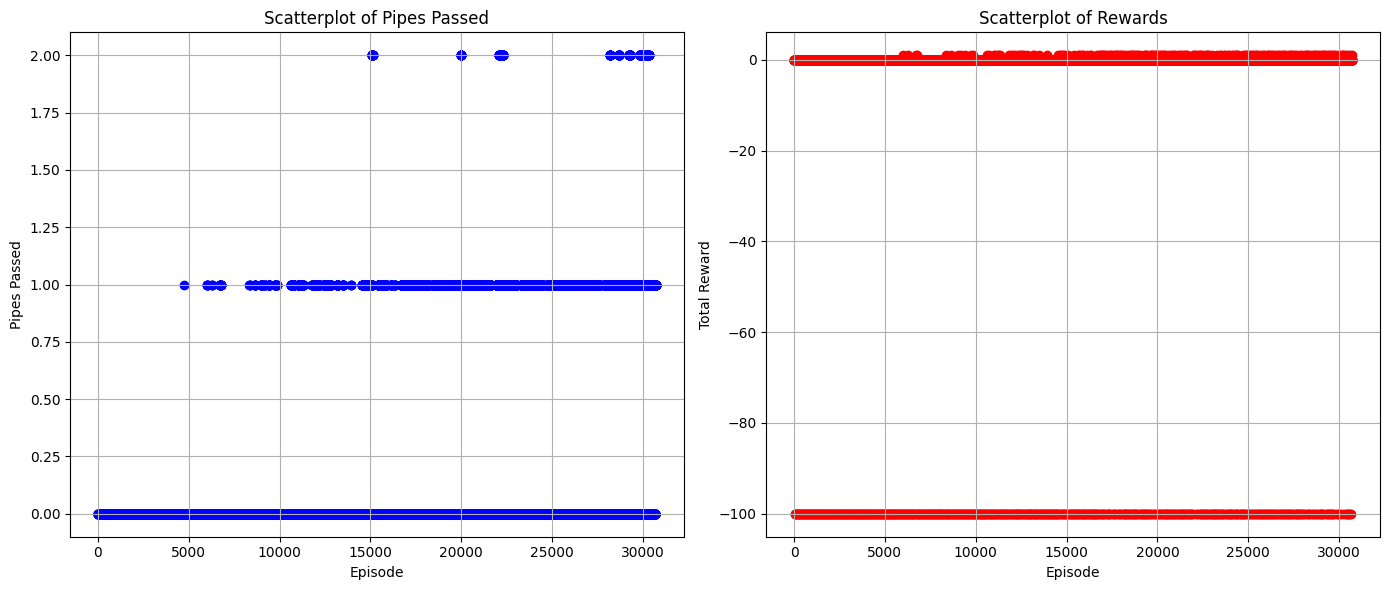

In [ ]:
rewards[1][0]
list_train_rewards = []
for i in range(0,len(rewards)):
    list_train_rewards.append(rewards[i][0])

df = pd.DataFrame({"Reward": list_train_rewards, "Pipes": pipe_counts})
df["Index"] = df.index

df["Pipes"].max()
print(df.loc[df["Pipes"]==df["Pipes"].max()])

# Scatterplots erstellen
plt.figure(figsize=(14, 6))

# Scatterplot für Pipes
plt.subplot(1, 2, 1)
plt.scatter(df['Index'], df['Pipes'], color='blue')
plt.title('Scatterplot of Pipes Passed')
plt.xlabel('Episode')
plt.ylabel('Pipes Passed')
plt.grid(True)

# Scatterplot für Rewards
plt.subplot(1, 2, 2)
plt.scatter(df['Index'], df['Reward'], color='red')
plt.title('Scatterplot of Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)

plt.tight_layout()
plt.show()

## Plotten des Rewards des Tests

   Reward  Pipes  Index
3     -98      2      3


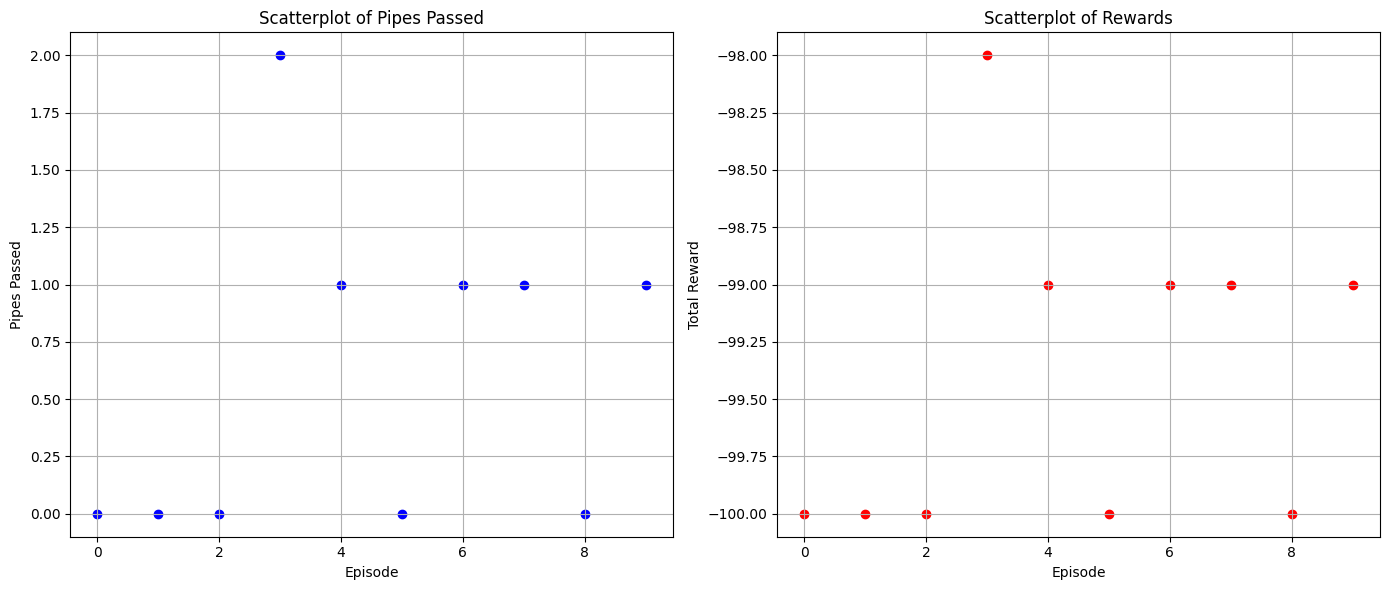

In [ ]:
df = pd.DataFrame({"Reward": list_rewards, "Pipes": pipe_counts_per_episode})
df["Index"] = df.index

df["Pipes"].max()
print(df.loc[df["Pipes"]==df["Pipes"].max()])

# Scatterplots erstellen
plt.figure(figsize=(14, 6))

# Scatterplot für Pipes
plt.subplot(1, 2, 1)
plt.scatter(df['Index'], df['Pipes'], color='blue')
plt.title('Scatterplot of Pipes Passed')
plt.xlabel('Episode')
plt.ylabel('Pipes Passed')
plt.grid(True)

# Scatterplot für Rewards
plt.subplot(1, 2, 2)
plt.scatter(df['Index'], df['Reward'], color='red')
plt.title('Scatterplot of Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)

plt.tight_layout()
plt.show()

# Baseline

In [ ]:
# Definiere die Heuristikfunktion
def heuristic(obs):
    bird_y = obs[1]
    threshold = 0.4 * 512  # 40% der Bildschirmhöhe
    return 1 if bird_y > threshold else 0

# Variablen zur Verfolgung des Fortschritts
total_timesteps = 20000
current_total_timesteps = 0
ep_rew_sum = 0
episode_rewards = []
episode_lengths = []

# Umgebung initialisieren
env = FlappyBirdEnv()
obs, _ = env.reset()

while current_total_timesteps < total_timesteps:
    action = heuristic(obs)
    obs, reward, terminated, _, _ = env.step(action)
    ep_rew_sum += reward
    current_total_timesteps += 1

    if terminated:
        episode_rewards.append(ep_rew_sum)
        episode_lengths.append(current_total_timesteps)
        obs, _ = env.reset()
        ep_rew_sum = 0

        # Fortschritt alle 100 Episoden protokollieren
        if len(episode_rewards) % 100 == 0:
            mean_reward = np.mean(episode_rewards[-100:])
            print(f"Episode: {len(episode_rewards)}, Total Timesteps: {current_total_timesteps}, Mean Reward (last 100 episodes): {mean_reward}")

# Umgebung schließen
env.close()

# Kumulative Timesteps und mittlere Rewards berechnen
cumulative_timesteps = np.cumsum(episode_lengths)
mean_rewards = [np.mean(episode_rewards[:i+1]) for i in range(len(episode_rewards))]

# Ergebnisse in ein DataFrame speichern
results_df = pd.DataFrame({
    'total_timesteps': cumulative_timesteps,
    'ep_rew_mean': mean_rewards
})

# Ergebnisse in eine Datei protokollieren
log_dir = "./logs/baseline_rew100_2Mio"
os.makedirs(log_dir, exist_ok=True)
baseline_log_file = os.path.join(log_dir, "progress.csv")
results_df.to_csv(baseline_log_file, index=False)

print(f"Results saved to {baseline_log_file}")

Episode: 100, Total Timesteps: 10078, Mean Reward (last 100 episodes): -98.96
Episode: 200, Total Timesteps: 19803, Mean Reward (last 100 episodes): -99.08


NameError: name 'os' is not defined